Étude de la stabilité et calcul automatique de CFL
===

Nous nous intéressons ici à résoudre un problème de transport du type :

$$
  u_t + u_x = 0
$$

avec $x\in[0,1]$ et $t>0$, ainsi que la condition initiale $u_0$ donnée. Les méthodes que nous allons présentées s'étendent à des problèmes de transport non linéaire : $u_t + f_x(u) = 0$, mais la seule généralisation qui nous intéressera sera une équation de transport à vitesse constante $a$ : $u_t + au+x = 0$.

La discrétisation en espace se concentrera sur des méthodes WENO, ou des différences finies centrées d'ordre 2 ; la discrétisation en temps se concentrera sur des méthodes de type Runge-Kutta. Par la suite, pour effectuer un lien avec l'équation de Vlasov-Poisson, nous nous intéresserons à un problème généralisé du type :

$$
  u_t = Lu + N(u)
$$

où $L$ représentera la partie linéaire de notre problème et $N$ la partie non linéaire. Ce problème nous permettra d'étudier la résolution en temps avec des schémas exponentiels.

In [425]:
"""
global import, and define common symbols
"""

import numpy as np
import matplotlib.pyplot as plt

import sympy as sp
from IPython.display import display
sp.init_printing()

from sympy import I

phi      = sp.symbols("\\phi",real=True) #,positive=True)
dx,dv,dt = sp.symbols("\\Delta\\ x \\Delta\\ v \\Delta\\ t",real=True,positive=True)
x,y = sp.symbols("x y",real=True)
z   = sp.symbols("z")

class Data(object):
  """
    dummy class to store data
  """
  def __str__(self):
    return "\n".join([ "{} : {}".format(k,v) for k,v in self.__dict__.items()])

default = Data()
default.figsize = plt.rcParams['figure.figsize']

import matplotlib.colors as mcolors # for mcolors.TABLEAU_COLORS
default.palette = list(mcolors.TABLEAU_COLORS)

In [426]:
# if need to reimport `plt` during a working session
from importlib import reload
plt = reload(plt)

In [427]:
def reim(Z):
  """
    function to split into 2 arrays real part and imaginary part of complex array
  """
  complex_to_tuple = lambda z:(z.real,z.imag)
  return tuple(map(list,zip(*map(complex_to_tuple,Z))))

def plot(expr,x,I,*args,**kwargs):
  """
    just plot a SymPy expression `expr` of variable `x` on the interval `I`
  """
  X = np.linspace(I[0],I[1],500)
  F = sp.lambdify(x,expr,'numpy')
  plt.plot(X,F(X),*args,**kwargs)

# just to store grid
data = Data()
# phi array to store angle where evaluate ztilde(phi)
data.phi = np.linspace(0,2.0*np.pi,1000)

# Discrétisations en espace

Pour étudier les schémas en espace nous allons utiliser l'analyse de *von Neumann*, pour cela introduisons quelques fonctions.

In [428]:
"""
  we will use von Neumann analysis to study WENO schemes
  this functions are helpers to write numerical flux of WENO and apply von Neumann analysis with sympy
"""

def f(k):
  """
    return $f_{i+k}$
  """
  if k==0:
    return sp.symbols("f_j")
  return sp.symbols("f_j%+d"%k)
  
def stencil(i_min,i_max) :
  """
    stencil
    return dictionary of (i,f_i) value between `i_min` and `i_max`
  """
  return dict(enumerate( [ f(i) for i in range(i_min,i_max+1) ] , start=i_min ))
f_stencil = stencil(-3,3) # stencil (-3,3) is the size of WENO5 stencil for hight order scheme need to grow up this one

def symbols_to( stencil , func ):
  """
    symbols_to
    convert dictionary `stencil` of `int => sp.Symbols` to dictionary of`sp.Symbols => sp.Symbols`
    useful to replace all $f_i$ symbols by an other value in expression
  """
  return { f:func(j,f) for j,f in stencil.items() }

def symbols_to_vonNeumann( stencil ):
  """
    symbols_to_vonNeumann
    convert all $f_i$ symbols to equivalent in von Neumann analysis with exponential
    $\phi$ symbol need to be initialized
  """
  return symbols_to( stencil , lambda j,_:sp.exp(I*j*phi) )

## Présentation de la méthode WENO5

La méthode WENO est une famille de schémas aux différences finies (il existe une interprétation en terme de volumes finis) d'ordre potentiellement élevé, essentiellement non oscillante à l'aide de différentes approximations pondérées. De manière générale, la méthode WENO peut être utilisée pour discrétiser la dérivée spatiale dans un problème de transport du type :

$$
  \partial_t u + \partial_x f(u) = 0
$$

Après une semi-discrétisation en espace, la méthode WENO consiste à approximer les flux numériques tels que :

$$
  \frac{\mathrm{d}u_j}{\mathrm{d}t} = -\frac{1}{\Delta x}\left( \hat{f}_{j_\frac{1}{2}} - \hat{f}_{j-\frac{1}{2}} \right)
$$

où $u_j(t) \approx u(t,x_j),\ j=0,\dots,N$. La méthode WENO, qui est une méthode *up-wind*, nécessite de *splitter* le flux entre sa partie positive et négative :

$$
  f(u) = f^+(u) + f^-(u)
$$

tel que $\frac{\mathrm{d}f^+}{\mathrm{d}u} \geq 0$ et $\frac{\mathrm{d}f^-}{\mathrm{d}u} \leq 0$. Nous noterons par la suite $f^\pm_j$ l\ approximation de $f^\pm(u(x_j))$ où $x_j$ est un point du maillage.

La méthode WENO consiste ensuite à estimer des poids en fonctions d'indicateurs de continuité (*indicators of smoothness*) $\beta_i^\pm$ (parfois noté $IS_i^\pm$), qui sont des combinaisons des carrés des approximations des dérivées successives en $x_j$ (sur des *stencils* potentiellement décentrés). Les coefficients $\beta_i^\pm$ permettent d'estimer des poids $w_i^\pm$, pondérant différentes estimations de la solution toujours en $x_j$ sur les différents *stencils*.

Pour le schéma *standard* WENO d'ordre 5 (aussi appelé WENO-JS pour [[G.-S. Jiang et C.-W. Shu (1996)]](http://doi.org/10.1006/jcph.1996.0130)) il y a 3 estimations sur 3 *stencils* différents :

$$
  \begin{aligned}
    \beta_0^+ &= \frac{13}{12}(\underbrace{f^+_{j-2} - 2f^+_{j-1} + f^+_{j}  }_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))}))^2 + \frac{1}{4}( \underbrace{f^+_{j-2} - 4f^+_{j-1} + 3f^+_{j}}_{2\Delta x( f'_j + \mathcal{O}(\Delta x^2))}  )^2 \\
    \beta_1^+ &= \frac{13}{12}( \underbrace{f^+_{j-1} - 2f^+_{j}   + f^+_{j+1}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x^2))} )^2 + \frac{1}{4}( \underbrace{f^+_{j-1} -  f^+_{j+1}}_{2\Delta x f'_j + \mathcal{O}(\Delta x^2))})^2 \\
    \beta_2^+ &= \frac{13}{12}( \underbrace{f^+_{j}   - 2f^+_{j+1} + f^+_{j+2}}_{\Delta x^2(f''_j + \mathcal{O}(\Delta x))} )^2 + \frac{1}{4}(\underbrace{3f^+_{j}   - 4f^+_{j+1} +  f^+_{j+2}}_{-2\Delta x( f'_j + \mathcal{O}(\Delta x^2))})^2 \\
  \end{aligned}
$$

et de manière similaire :

$$
  \begin{aligned}
    \beta_0^- &= \frac{13}{12}(f^-_{j+1} - 2f^-_{j+2} + f^-_{j+3})^2 + \frac{1}{4}(3f^-_{j+1} - 4f^-_{j+2} +  f^-_{j+3})^2 \\
    \beta_1^- &= \frac{13}{12}(f^-_{j}   - 2f^-_{j+1} + f^-_{j+2})^2 + \frac{1}{4}( f^-_{j}   -  f^-_{j+2})^2 \\
    \beta_2^- &= \frac{13}{12}(f^-_{j-1} - 2f^-_{j}   + f^-_{j+1})^2 + \frac{1}{4}( f^-_{j-1} - 4f^-_{j}   + 3f^-_{j+1})^2 \\
  \end{aligned}
$$

Ensuite nous calculons les poids non normalisés :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\varepsilon + \beta_i^\pm)^2},\quad i=0,1,2
$$
où $\varepsilon$ est un paramètre numérique pour assurer la non nullité du dénominateur, il sera pris à $10^{-6}$ ; et vaec $\gamma_0=\frac{1}{10}$, $\gamma_1=\frac{6}{10}$ et $\gamma_2=\frac{3}{10}$. La normalisation des poids s'effectue comme suit :

$$
  w_i^\pm = \frac{\alpha_i^\pm}{\sum_m \alpha_m^\pm},\quad i=0,1,2
$$

Nous pouvons ensuite calculer les flux numériques pour WENO5, donnés par :


$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^+   =\ & w_0^+\left(  \frac{2}{6}f^+_{j-2} - \frac{7}{6}f^+_{j-1} + \frac{11}{6}f^+_{j}   \right)
                                +    w_1^+\left( -\frac{1}{6}f^+_{j-1} + \frac{5}{6}f^+_{j}   +  \frac{2}{6}f^+_{j+1} \right) \\
                                +  & w_2^+\left(  \frac{2}{6}f^+_{j}   + \frac{5}{6}f^+_{j+1} -  \frac{1}{6}f^+_{j+2} \right)
  \end{aligned}
$$

et

$$
  \begin{aligned}
    \hat{f}_{j+\frac{1}{2}}^-   =\ & w_2^-\left( -\frac{1}{6}f^-_{j-1} + \frac{5}{6}f^-_{j}   + \frac{2}{6}f^-_{j+1} \right)
                                +    w_1^-\left(  \frac{2}{6}f^-_{j}   + \frac{5}{6}f^-_{j+1} - \frac{1}{6}f^-_{j+2} \right) \\
                                +  & w_0^-\left( \frac{11}{6}f^-_{j+1} - \frac{7}{6}f^-_{j+2} + \frac{2}{6}f^-_{j+3} \right)
  \end{aligned}
$$

La méthode WENO5 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(\hat{f}_{j+\frac{1}{2}}^+ - \hat{f}_{j-\frac{1}{2}}^+ \right) + \left(\hat{f}_{j+\frac{1}{2}}^- - \hat{f}_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

### Linéarisation du schéma WENO5

Le schéma WENO n'étant pas linéaire, son étude est en dehors du cadre classique de l'analyse de von Neumann. L'étude de la stabilité du schéma WENO avec différents schémas en temps, initié dans [[R. Wang and R. J. Spiteri (2007)]](https://doi.org/10.1137/050637868) et repris dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) s'effectue à partir d'une linéarisation du schéma WENO, le calcul complet y est présenté, nous utiliserons ici que le résultat, issu d'un développement limité des poids non linéaire de la méthode WENO. Le développement limité nous donne une linéarisation des poids en :

$$
  \alpha_i^{\pm} = \gamma_i + \mathcal{O}(\Delta x^2)
$$

les poids $w_i^{\pm}$ s'écrivent alors :

$$
  w_i^{\pm} = \gamma_i + \epsilon_i^{\pm}
$$

avec $\epsilon_i = \mathcal{O}(\Delta x^2)$. Le coefficient d'amplification du schéma WENO linarisé s'écrit :

$$
  \lambda^{\ell W}(\phi) = \tilde{z}(\phi) + M(\{\epsilon_i^{\pm}\}_i,\phi)
$$

où $\tilde{z}$ correspond à la partie linéarie de WENO5 et $M$, dépendant de la famille des $\{\epsilon_i\}_i$, la partie non linéaire. Wang et Spiteri montrent qu'il est possible de majorer $M$ en remarquant que $M(\{\epsilon_i^{\pm}\}_i,\phi) = \mathcal{O}(\max_i(\epsilon_i))$. La fonction $\tilde{z}$ étant lin\eaire, il est possible d'effectuer son analyse de stabilité à l'aide de l'analyse de von Neumann.

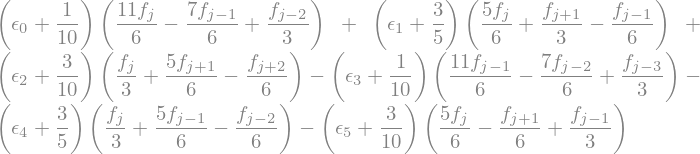

In [773]:
"""
linearized WENO method
"""
weno5l = Data()
weno5l.name = "linearized WENO5"

ei = sp.symbols("\\epsilon_0:6",real=True)

def weno5l_flux () :
  w0 = sp.Rational(1,10) + ei[0]
  w1 = sp.Rational(6,10) + ei[1]
  w2 = sp.Rational(3,10) + ei[2]
  
  w3 = sp.Rational(1,10) + ei[3]
  w4 = sp.Rational(6,10) + ei[4]
  w5 = sp.Rational(3,10) + ei[5]
  
  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[3],ei[1]:ei[4],ei[2]:ei[5]})
  
  return fjp12 - fjm12

weno5l.flux = weno5l_flux()
del weno5l_flux
display(weno5l.flux)



Le flux de WENO5 non linéarisé fait intervenir les $\epsilon_i$ dont la contribution est difficilement quantifiable. On réécrit $\lambda^{\ell W} = \tilde{z} + \mathcal{O}(\Delta x^2)$, et on néglige tous les termes d'ordre $\Delta x^2$ et suppérieur.

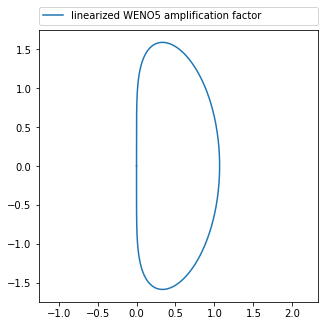

In [774]:
weno5l.ztilde = Data()

weno5l.ztilde.flux = weno5l.flux.expand().subs([(e,0) for e in ei])
weno5l.ztilde.func = sp.lambdify(phi,weno5l.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
weno5l.ztilde.data = weno5l.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(weno5l.ztilde.data),label=weno5l.name+" amplification factor")
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

On retrouve ainsi la courbe en *haricot* décrite dans [[M. Motamed and C. B. Macdonald and S. J. Ruuth (2010)]](https://doi.org/10.1007/s10915-010-9423-9) ou [[D. Ketcheson and C. B. Macdonald and S. J. Ruuth (2013)]](https://doi.org/10.1137/130906258).

On peut maintenant s'intéresser aux non linéarités $M(\{\epsilon_i^\pm\}_i)$

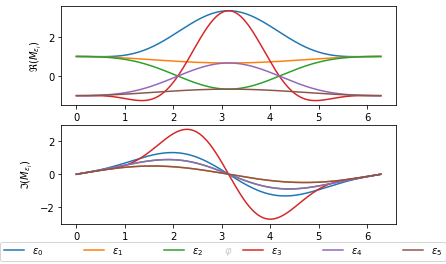

In [431]:
weno5l.M = Data()

weno5l.M.flux = (weno5l.flux.expand() - weno5l.ztilde.flux).collect(ei)
weno5l.M.func = [ sp.lambdify(phi,arg.subs([(e,1) for e in ei]),'numpy')
                  for arg in weno5l.M.flux.subs(symbols_to_vonNeumann(f_stencil)).args ]
weno5l.M.data = [ fun(data.phi) for fun in weno5l.M.func ]

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xlabel("$\\varphi$"); ax1.set_ylabel("$\\Re(M_{\\epsilon_i})$")
ax2.set_xlabel("$\\varphi$"); ax2.set_ylabel("$\\Im(M_{\\epsilon_i})$")

for i,dat in enumerate(weno5l.M.data):
  ax1.plot(data.phi,dat.real,label="$\\epsilon_{}$".format(i))
  ax2.plot(data.phi,dat.imag,label="$\\epsilon_{}$".format(i))

handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.01),ncol=len(weno5l.M.data),mode="expand",borderaxespad=0.)
plt.show()

del fig,ax1,ax2,i,dat,handles,labels

En réalité la valeur des différentes composantes de $M$ nous importent peu. Ce qu'il faut remarquer est la forme général de chaque composante, prenons comme exemple la composante $\epsilon_0$ :

$$
  \begin{aligned}
    \Re \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Re}|\epsilon_0| \\
    \Im \left| \epsilon_0\left(\frac{11}{6} -\frac{7}{6}e^{-i\phi} + \frac{1}{3}e^{-2i\phi}\right)\right| &\leq c_0^{\Im}|\epsilon_0|
  \end{aligned}
$$

avec $c_0^{\Re|\Im}$ des constantes positives. Dans [[Wang R. and Spiteri R. J. (2007)]](https://doi.org/10.1137/050637868), une estimation de $c_0^{\Re}=\frac{10}{3}$ est prise comme exemple. On majore ainsi toutes les composantes en $\epsilon_i$ de $M$, on se retrouve alors avec :

$$
  \begin{aligned}
    \left|\Re\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Re}\max_{0\leq m \leq 5}|\epsilon_m| \\
    \left|\Im\left(M(\{\epsilon_i\}_{i=0,\dots,5},\phi)\right)\right| &\leq \Gamma^{\Im}\max_{0\leq m \leq 5}|\epsilon_m|
  \end{aligned}
$$

avec $\Gamma^{\Re|\Im}$ des constantes postives ne dépendant que de la taille du *stencil* considéré. Cela permet de justifier $M = \mathcal{O}(\Delta x^2)$.

On peut vérifier quelques propriétés de ce schéma WENO linéarisé. Ce schéma correspond à l'approximation des poids $w_i^\pm = \gamma_i$, c'est-à-dire que les *indicators of smoothness* valent tous 1, ce qui se justifie avec une fonction suffisamment régulière.

On implémente dans un premier temps nos schémas en espace :

* `weno` : le schéma WENO classique d'ordre 5,
* `weno_lin` : le schéma WENO d'ordre 5 linéarisé, que l'on souhaite tester,
* `cd2` : le schéma de différences finies centrées d'ordre 2, qui nous sert plus pour débugger.

Puis le schéma en temps, on se contentera d'un schéma de type Runge-Kutta d'ordre 3 à 3 étages : RK(3,3) (avec la fonction `rk33`). Ce schéma est d'ordre inférieur en temps, l'erreur sattuera donc rapidement en $\Delta t^3$.

In [772]:
def _weno(u_i,dx):
  """
    weno
    return the WENO approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

def _weno_lin(u_i,dx):
  """
    weno_lin
    return the linearized WENO approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  w0,w1,w2 = [ g_i for g_i in (0.1,0.6,0.3) ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

def _cd2(u_i,dx):
  """
    cd2
    return the centred differiencies of order 2 of $\partial_x u$
  """
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])

  return (u_ip1-u_im1)/(2.0*dx)

def rk33(un,L,dt,*config):
  """
    rk33
    return the one iteration of Runge-Kutta approximation of
    $\dot{u} = L(u,config)$ with initial condtion `un`
  """
  u1 = un + dt*L(un,*config)
  u2 = 0.75*un + 0.25*u1 + 0.25*dt*L(u1,*config)
  return (1./3.)*un + (2./3.)*u2 + (2./3.)*dt*L(u2,*config)

weno5 = Data()
weno5.name = "WENO5"
weno5.func = _weno

weno5l.func = _weno_lin

cd2 = Data()
cd2.name = "CD2"
cd2.func = _cd2

del _weno,_weno_lin,_cd2

On teste nos schémas avec un problème de transport :

$$
  \begin{cases}
    u_t + u_x = 0 \\
    u(t=0,x) = u_0(x) = \cos(x)
  \end{cases}
$$

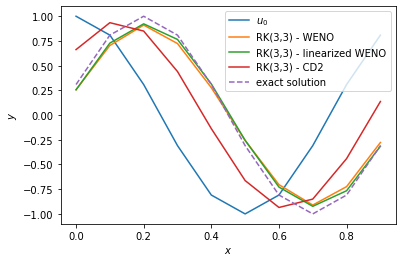

In [491]:
def transport(u0,rk,L,Tf,dt):
  r"""
    transport
    use `rk` method with `L` discretisation in space to solve :
    $u_t = L(u),\ u(t=0)=\texttt{u0}$,
    to the time `Tf`, with time step `dt`, $x\in[0,1]$ so length
    of `u0` gives the space step.
  """
  N = len(u0)
  u = u0
  dx = 1./N

  niter = 0
  while niter*dt < Tf :
    u = rk(u,L,dt,dx)
    niter += 1
  
  return u

num_param = Data()

num_param.N = 10
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
num_param.u_0 = np.cos(2.*np.pi*num_param.X)

num_param.Tf = 1.2
num_param.dt = 1./num_param.N # = dx; a classical CFL

u_cd2   = transport(num_param.u_0,rk33,lambda u,dx:-cd2.func(u,dx)   ,num_param.Tf,num_param.dt)
u_weno  = transport(num_param.u_0,rk33,lambda u,dx:-weno5.func(u,dx) ,num_param.Tf,num_param.dt)
u_wenol = transport(num_param.u_0,rk33,lambda u,dx:-weno5l.func(u,dx),num_param.Tf,num_param.dt)
u_exact = np.cos(2.*np.pi*(num_param.X - num_param.Tf))

plt.plot(num_param.X,num_param.u_0,label="$u_0$")
plt.plot(num_param.X,u_weno,label="RK(3,3) - "+weno5.name)
plt.plot(num_param.X,u_wenol,label="RK(3,3) - "+weno5l.name)
plt.plot(num_param.X,u_cd2,label="RK(3,3) - "+cd2.name)
plt.plot(num_param.X,u_exact,"--",label="exact solution")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.legend()
plt.show()

del num_param

In [484]:
class error:
  """
    error
    compute and store error between an exact solution and an approximation solution
    errors are computed in norm 1, 2 and infinity
  """
  def __init__(self,u,v):
    import math
    diff = u-v
    dx = 1./(len(u))
    self.n1 = math.fsum([abs(x) for x in diff])*dx
    self.n2 = math.sqrt(math.fsum(diff*diff))*dx
    self.noo = abs(max(diff,key=lambda x:abs(x)))
  
  def __str__(self):
    return """{} {} {}""".format(self.n1,self.n2,self.noo)
  def __repr__(self):
    return "error<{},{},{}>".format(self.n1,self.n2,self.noo)


print("""
error in norm 1, 2 and infinity
WENO error            : {}
linearized WENO error : {}
centred differencies 2: {}
""".format( error(u_weno,u_exact) , error(u_wenol,u_exact) , error(u_cd2,u_exact)) )


error in norm 1, 2 and infinity
WENO error            : 0.0727358076583417 0.024515017107707204 0.10507133395404789
linearized WENO error : 0.05219688953416793 0.018565045399276857 0.08064862959784924
centred differencies 2: 0.28880497730726834 0.09982004218314153 0.4462282302400852



On peut maintenant calculer l'ordre de la méthode sur ce problème de transport, en calculant la solution pour différents $\Delta x$ (on choisit différentes tailles de vecteur en entré), jusqu'au temps $T_f=1$ avec un pas de temps $\Delta t = \frac{1}{400}$ qui correspond environ à $\Delta t \leq \frac{1}{2}\Delta x_{\text{min}}$, pour minimiser l'erreur en temps.

In [485]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_wenol = []
errors_weno  = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_fl = transport(u_0,rk33,lambda u,dx:-weno5l.func(u,dx),num_param.Tf,num_param.dt)
    u_f  = transport(u_0,rk33,lambda u,dx:-weno5.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenol.append( (N,error(u_fl,u_e)) )
    errors_weno.append( (N,error(u_f,u_e)) )

del N,num_param,u_0,u_e,u_fl,u_f

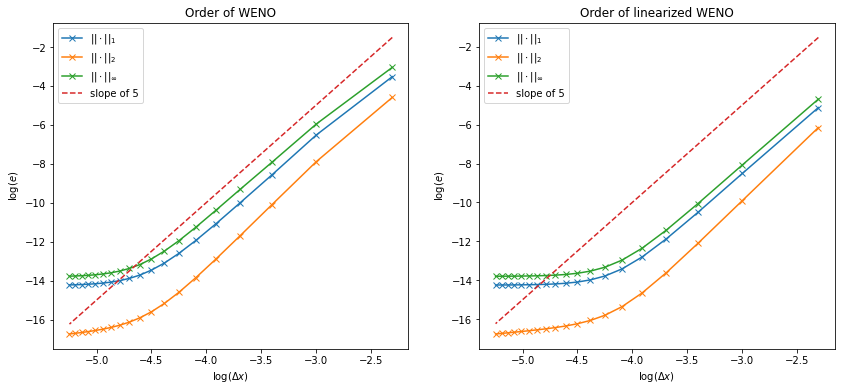

In [492]:
space_steps = np.array([ 1./e[0] for e in errors_weno ])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.set_title("Order of "+weno5.name)
ax1.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{1}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{2}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax1.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
ax1.set_xlabel(r"$\log(\Delta x)$")
ax1.set_ylabel(r"$\log(e)$")
ax1.legend()

ax2.set_title("Order of "+weno5l.name)
ax2.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{1}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{2}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenol ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax2.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
ax2.set_xlabel(r"$\log(\Delta x)$")
ax2.set_ylabel(r"$\log(e)$")
ax2.legend()

plt.show()

del fig,ax1,ax2,space_steps

On remarque bien une pente d'ordre 5 avec le schéma WENO linéarisé.

La linéarisation du schéma WENO suppose que la fonction est suffisamment régulière. On peut donc chercher à étuider son comportement face à une discontinuité, en transportant à vitesse 1 une fonction créneau. La condition initiale est donnée par :

$$
  u(t=0,x) = \begin{cases}
    4x & \text{si } x\in[0,\frac{1}{4}] \\
    1  & \text{si } x\in[\frac{1}{4},\frac{3}{4}] \\
    0  & \text{sinon}
  \end{cases}
$$

La simulation s'effectue jusqu'au temps $T_f = 1$ sur un domaine périodique $[0,1]$, avec $N_x = 20$ le nombre de points de disctétisation, et la condition CFL $\Delta t = 0.1\Delta x$ toujours avec le schéma Runge-Kutta d'ordre 3 RK(3,3). Le temps final étant un multiple du domaine en espace, avec une vitesse d'advection de 1, la solution exacte du problème est la condition initiale.

CD2
WENO
linearized WENO


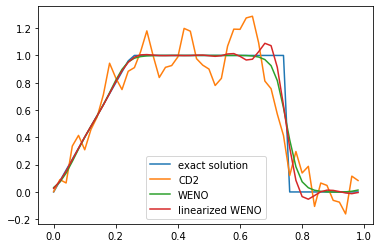

In [596]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (cd2,weno5,weno5l):
  print(scheme.name)
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

del u_0, num_param,schemes_u

On remarque que le schéma WENO linéarisé oscille à proximité d'une discontinuité, le schéma WENO classique quant à lui devient plus visqueux à l'aide des poids qui permettent d'effectuer une meilleure interpolation qu'une interpolation polynomiale de degré élevé induisant localement des oscillations.

On peut étudier la réponse du schéma WENO linéarisé à un cosinus. La méthode servant à approximer une dérivée, on peut vérifier ce comportement, connaissant la solution exacte.

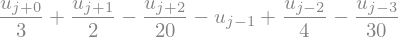

In [422]:
weno5l.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.symbols("u_{j%+d}"%j)))

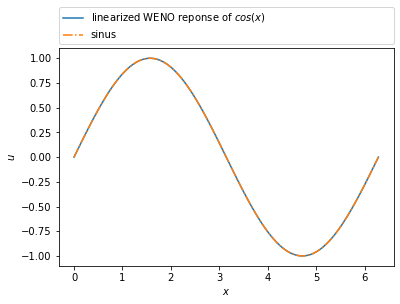

In [449]:
data.phi100 = np.linspace(0,2.0*np.pi,100)
data.deltaX = 2.*np.pi/data.phi100.size
weno5l.ztilde.sinapprox = -sp.lambdify(x,weno5l.ztilde.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx))).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,weno5l.ztilde.sinapprox,label=weno5l.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

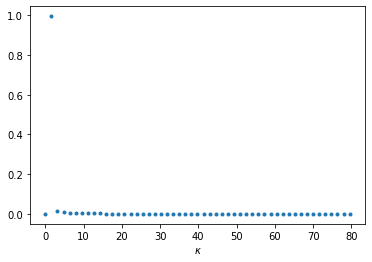

In [451]:
plt.plot( np.fft.rfftfreq(weno5l.ztilde.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.abs(np.fft.rfft(weno5l.ztilde.sinapprox))*2./weno5l.ztilde.sinapprox.size , "." )
plt.xlabel(r"$\kappa$")
plt.show()

Le résultat semble satisfaisant, regardons maintenant la différence entre les deux. L'erreur commise par WENO est de $10^{-8}$, avec un $\Delta x = \frac{2\pi}{100}$ (soit $\Delta x^{6}$ ce qui est attendu avec un schéma d'ordre 5).

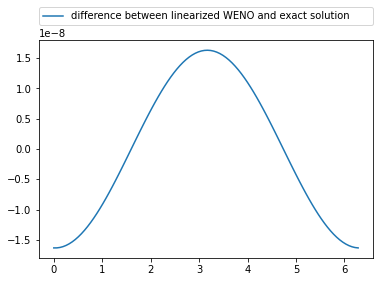

In [453]:
plt.plot(data.phi100,weno5l.ztilde.sinapprox-np.sin(data.phi100),label="difference between "+weno5l.name+" and exact solution")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [474]:
(data.deltaX**5,max(weno5l.ztilde.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

On trouve bien une différence pas très loin de l'ordre de $\Delta x^5$ ce qui nous permet, selon la définition de l'ordre, de considérer le schéma comme d'ordre 5.

L'étude se faisant automatiquement avec `sympy`, il est simple d'effectuer cette étude de coefficients de Fourier avec le schéma WENO standard non linéarisé. L'étude de l'analyse de von Neumann aussi mais il est impossible de justifier mathématiquement les résultats obtenus.

In [456]:
"""
  complet WENO method
"""
epsilon = sp.symbols("\\epsilon",real=True,positive=True)

def weno5_flux () :
  IS0 = sp.Rational(13,12)*( f(-2) - 2*f(-1) + f(+0) )**2 + sp.Rational(1,4)*( f(-2) - 4*f(-1) + 3*f(+0) )**2
  IS1 = sp.Rational(13,12)*( f(-1) - 2*f(+0) + f(+1) )**2 + sp.Rational(1,4)*( f(-1) - f(+1) )**2
  IS2 = sp.Rational(13,12)*( f(+0) - 2*f(+1) + f(+2) )**2 + sp.Rational(1,4)*( f(+2) - 4*f(+1) + 3*f(+0) )**2

  a0 = sp.Rational(1,10)*(1/(epsilon+IS0))**2
  a1 = sp.Rational(6,10)*(1/(epsilon+IS1))**2
  a2 = sp.Rational(3,10)*(1/(epsilon+IS2))**2
  
  s = a0 + a1 + a2
  w0 = a0 / s
  w1 = a1 / s
  w2 = a2 / s

  fjp12 = ( w0*( sp.Rational(2,6)*f(-2) - sp.Rational(7,6)*f(-1) + sp.Rational(11,6)*f(+0) )
          + w1*(-sp.Rational(1,6)*f(-1) + sp.Rational(5,6)*f(+0) +  sp.Rational(2,6)*f(+1) )
          + w2*( sp.Rational(2,6)*f(+0) + sp.Rational(5,6)*f(+1) -  sp.Rational(1,6)*f(+2) ) )
  # we define fjm12 as fjp12 where f(j) is substitute by f(j-1)
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True)
  
  return fjp12 - fjm12

weno5.flux = weno5_flux()
del weno5_flux

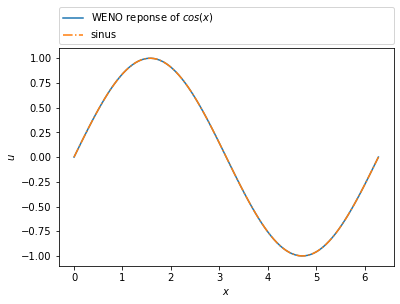

In [457]:
weno5.sinapprox = sp.lambdify(x,-(weno5.flux.subs(symbols_to(f_stencil,lambda j,_:sp.cos(x+j*dx)))).subs(epsilon,10**(-6)).subs(dx,data.deltaX)/data.deltaX,'numpy')(data.phi100)
plt.plot(data.phi100,weno5.sinapprox,label=weno5.name+r" reponse of $cos(x)$")
plt.plot(data.phi100,np.sin(data.phi100),"-.",label="sinus")
plt.xlabel("$x$"); plt.ylabel("$u$")
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()

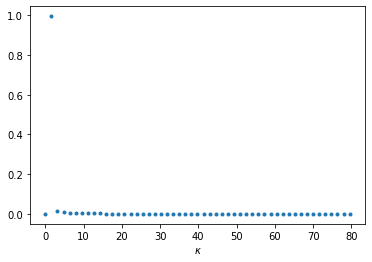

In [458]:
plt.plot( np.fft.rfftfreq(weno5.sinapprox.size,2.*np.pi/data.phi.size) ,
         np.abs(np.fft.rfft(weno5.sinapprox))*2./weno5.sinapprox.size , '.' )
plt.xlabel(r"$\kappa$")
plt.show()

On peut maintenant tracer la différence entre les coefficients de Fourier des 2 résultats, entre WENO et WENO linéarisé.

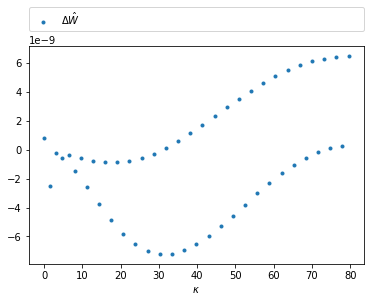

In [460]:
plt.plot( np.fft.rfftfreq(weno5.sinapprox.size,2.*np.pi/data.phi.size) ,
          np.abs(np.fft.rfft(weno5.sinapprox))*2./weno5.sinapprox.size - np.abs(np.fft.rfft(weno5l.ztilde.sinapprox))*2./weno5l.ztilde.sinapprox.size ,
         '.' , label=r"$\Delta \hat{W}$")
plt.xlabel(r"$\kappa$")
plt.legend(loc=(0.,1.07),mode="expand",borderaxespad=0.)
plt.show()

In [465]:
(data.deltaX**5,max(weno5.sinapprox-np.sin(data.phi100),key=lambda x:np.abs(x)))

## Méthodes WENO modifiées

Il existe différentes méthodes de calcul des poids du schéma WENO d'ordre 5, qui ont été listées et comparées [ici](https://github.com/wme7/WENO5-X) par Manuel A. Diaz. Nous étudirons ici leur différents coefficients d'amplification.

La différence réside uniquement dans l'estimation des poids, les indicateurs de continuité $\beta_i$ ainsi que les coefficients $\gamma_i$ restent identique.

| Méthode     | Calcul des poids $w_i$ | Parmètres |
|-------------|------------------------|-----------|
| **WENO-JS** | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-6}$                              |
| **WENO-M**  | $$\begin{aligned}\alpha_i &\gets \frac{\gamma_i}{(\epsilon + \beta_i)^2} \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \\ g_i &\gets w_i\left(\frac{\gamma_i + \gamma_i^2 - 3w_i\gamma_i + w_i^2}{\gamma_i^2+w_i(1-2\gamma_i)}\right) \\ w_i &\gets \frac{g_i}{\sum g_k} \end{aligned}$$ | $\epsilon = 10^{-6}$ |
| **WENO-Z**  | $$\begin{aligned}\alpha_i &\gets \gamma_i\left(1+\frac{\tau_5}{\epsilon + \beta_i}\right) \\ w_i &\gets \frac{\alpha_i}{\sum \alpha_k} \end{aligned}$$ | $\epsilon = 10^{-40}$, $\tau_5 = |\beta_0-\beta_2|$ |

La méthode WENO-JS est la méthode WENO *classique* de Jiang et Shu et sert juste pour la comparaison avec WENO-M (WENO avec une fonction de *mappage*) et WENO-Z. L'objectif de ces méthodes est de minimiser la perte d'ordre à l'approche d'une discontinuité, donc d'approter moins de viscosité numérique.

### WENO-M

La méthode WENO-M fonctionnne à l'aide d'une fonction dite de *mappage* : $g_i$. Cette fonction est définie par :

$$
  g_i : w \mapsto w\left( \frac{\gamma_i + \gamma_i^2 - 3w\gamma_i + w^2}{\gamma_i^2 + w(1-2\gamma_i)} \right)
$$

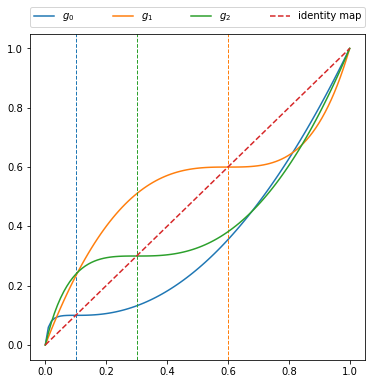

In [475]:
w,gamma_i = sp.symbols("w \\gamma_i",real=True)
g = w*(gamma_i+gamma_i**2-3*w*gamma_i+w**2)/(gamma_i**2+w*(1-2*gamma_i))

plt.rcParams['figure.figsize'] = [6,6]
linW = np.linspace(0,1.0,100)
for i,gi in enumerate([sp.Rational(1,10),sp.Rational(6,10),sp.Rational(3,10)]) :
  plt.plot(linW,sp.lambdify(w,g.subs(gamma_i,gi),'numpy')(linW),label="$g_{}$".format(i),color=default.palette[i])
  plt.axvline(gi,color=default.palette[i],linestyle='--',linewidth=1.)
plt.plot(linW,linW,"--",label="identity map",color=default.palette[3])
plt.legend(loc=(0.,1.02),ncol=4,mode="expand",borderaxespad=0.)
plt.show()

display(sp.Eq( sp.symbols("g_i'(\\gamma_i)") , g.diff(w).subs(w,gamma_i).simplify() ))
del w,gamma_i,g,linW,i,gi
plt.rcParams['figure.figsize'] = default.figsize

Les fonctions $g_i$ n'ont besoin d'être définie que sur l'intervalle $[0,1]$ puisque les poids d'une méthode WENO vérifient $\sum_k w_k=1$ et $w_k\leq0\,\forall k$. Les points fixes de la fonction de *mappage* $g_i$ sont les 2 valeurs triviales 0 et 1, ainsi que $\gamma_i$ (la valeur linéarisé du poids). La fonction $g_i$ sera évaluée en $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, ce qui nous intéresse est donc son évaluation en des points proches de $\gamma_i$. On remarque que la dérivée de $g_i$ est nulle (donc un plateau) en $\gamma_i$ et que $g_i(\gamma_i) = \gamma_i$, cela permet de forcer une certaine linéarisation des poids, sans pour autant faire apparaître des oscillations.

Pour une étude plus approfondie de cette méthode avec l'analyse de *von Neumann*, on peut remarquer que la linéarisation des poids donne toujours $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$. L'analyse qui en suit sera identique.

In [499]:
def _wenom(u_i,dx):
  """
    _wenom
    return the WENO-M approximation of $\partial_x u$
  """
  def g(gi,w):
    return w*(( gi + gi*gi - 3.*w*gi + w*w )/( gi*gi + w*(1.-2.*gi) ))

  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]
  g_weights = [ g(gi,w) for gi,w in zip((0.1,0.6,0.3),(w0,w1,w2)) ]
  sum_g = sum(g_weights)
  w0,w1,w2 = [ g_i/sum_g for g_i in g_weights ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno5m = Data()
weno5m.name = "WENO5-M"
weno5m.func = _wenom
del _wenom

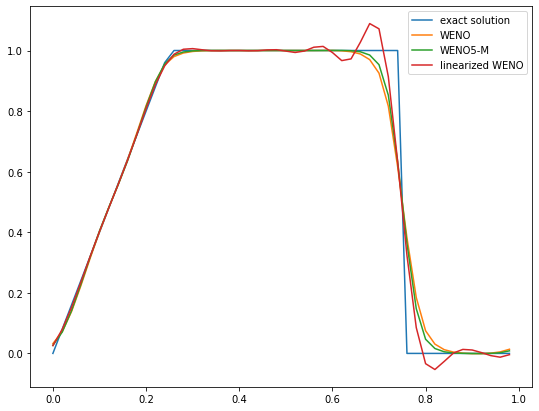

In [698]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5l):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

On vérifie l'ordre de la méthode, qui est bien d'ordre 5.

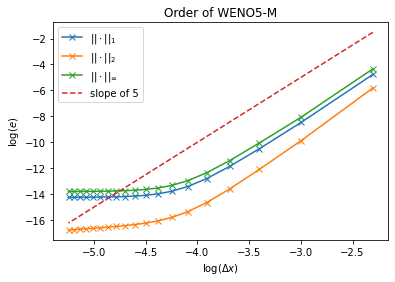

In [776]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_wenom = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33,lambda u,dx:-weno5m.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenom.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_wenom ])

plt.title("Order of "+weno5m.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenom ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()

del N,num_param,u_0,u_e,u_f,space_steps,errors_wenom

### WENO-Z

La méthode WENO-Z consiste à minimiser la baisse d'ordre à l'approche d'une discontinuité. Dans le cadre de la simulation de plasmas, nous savons que nos fonctions de distribution seront continue, l'ordre élevé est nécessaire pour capturer correctement les forts gradients.

Pour l'analyse de stabilité, la linéarisation des poids donne aussi $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$, l'analyse de *von Neumann* du schéma linéarisé reste donc la même.

In [658]:
def _wenoz(u_i,dx):
  """
    _wenoz
    return the WENO-z approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  b0 = 13./12.*np.square( u_im2 - 2.*u_im1 + u_i   ) + 0.25*np.square(    u_im2 - 4.*u_im1 + 3.*u_i   )
  b1 = 13./12.*np.square( u_im1 - 2.*u_i   + u_ip1 ) + 0.25*np.square(    u_im1            -    u_ip1 )
  b2 = 13./12.*np.square( u_i   - 2.*u_ip1 + u_ip2 ) + 0.25*np.square( 3.*u_i   - 4.*u_ip1 +    u_ip2 )
  tau5 = np.abs(b0-b2)
  alpha  = [ g_i*(1. + tau5/(1e-40 + b_i)) for b_i,g_i in zip((b0,b1,b2),(0.1,0.6,0.3)) ]
  sum_alpha = sum(alpha)
  w0,w1,w2 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = ( w0*( (2./6.)*u_im2 - (7./6.)*u_im1 + (11./6.)*u_i   )
          + w1*(-(1./6.)*u_im1 + (5./6.)*u_i   +  (2./6.)*u_ip1 )
          + w2*( (2./6.)*u_i   + (5./6.)*u_ip1 -  (1./6.)*u_ip2 ))
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno5z = Data()
weno5z.name = "WENO5-Z"
weno5z.func = _wenoz
del _wenoz

On représente tous les schémas WENO d'ordre 5, ainsi que la version linéarisé pour les comparer. Tout d'abord avec la condition initiale qui fait intervenir une dicontinuité de gradient et une dicontinuité en temps court $T_f=1$, c'est-à-dire une seule période du domaine.

$$
  u(t=0,x) = u_0(x) = \begin{cases}
    4x & \text{si } x\in[0,\frac{1}{4}] \\
    1  & \text{si } x\in[\frac{1}{4},\frac{3}{4}] \\
    0  & \text{sinon}
  \end{cases}
$$

On remarque que la version linéarisé réagit très bien à la discontinuité du gradient mais oscille au niveau de la discontinuité. Le schéma WENO-Z est bien celui minimisant la perte d'ordre, donc la viscosité, sans osciller au niveau de la dicontinuité.

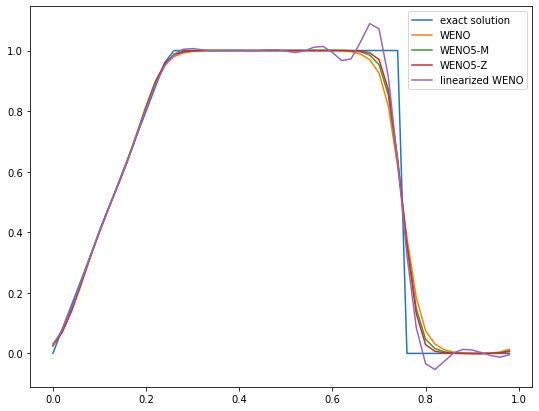

In [659]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

On regarde aussi la réponse des différents schémas face à un créneau, toujours en temps court $T_f = 1$.

$$
  u(t=0,x) = u_0(x) = \mathbb{1}_{[\frac{1}{4},\frac{3}{4}]}(x)
$$

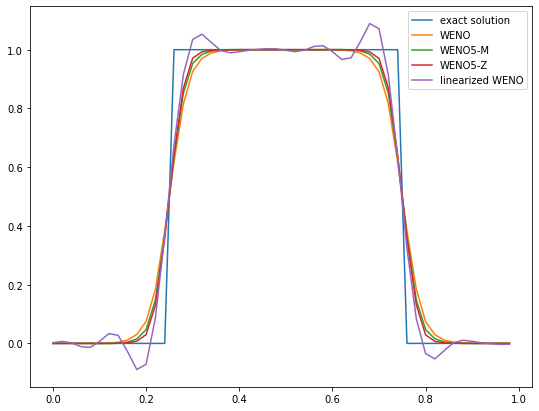

In [704]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

Avant de faire des tests en temps long, nous allons vérifier l'ordre de la méthode WENO-Z.

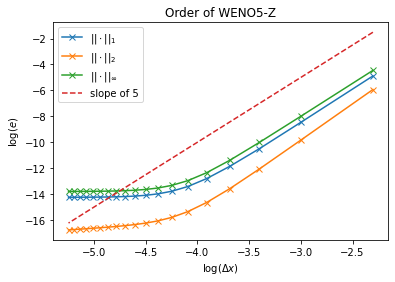

In [777]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_wenoz = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33,lambda u,dx:-weno5z.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_wenoz.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_wenoz ])

plt.title("Order of "+weno5z.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_wenoz ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()

del N,num_param,u_0,u_e,u_f,space_steps,errors_wenoz

Maintenant nous allons effectuer 3 tests en temps long, $T_f=100$. Les deux premiers se feront avec les mêmes conditions initiales que précédemment :

$$
  u(t=0,x) = u_0(x) = \begin{cases}
    4x & \text{si } x\in[0,\frac{1}{4}] \\
    1  & \text{si } x\in[\frac{1}{4},\frac{3}{4}] \\
    0  & \text{sinon}
  \end{cases}
$$

$$
  u(t=0,x) = u_0(x) = \mathbb{1}_{[\frac{1}{4},\frac{3}{4}]}(x)
$$

Le troiìeme test s'effectue sur une fonction chapeau, en temps court celle-ci ne présente pas de réel intérêt, en temps plus long on y voit apparaître les défauts des différents schémas dans des conditions plus favorable d'un créneau.

$$
  u(t=0,x) = u_0(x) = \begin{cases}
     4x-1 & \text{si } x\in[\frac{1}{4},\frac{1}{2}] \\
    -4x+3 & \text{si } x\in[\frac{1}{2},\frac{3}{4}] \\
    0     & \text{sinon}
  \end{cases}
$$

WENO
WENO5-M
WENO5-Z
linearized WENO
WENO 0
WENO5-M 18
WENO5-Z 1
linearized WENO 24


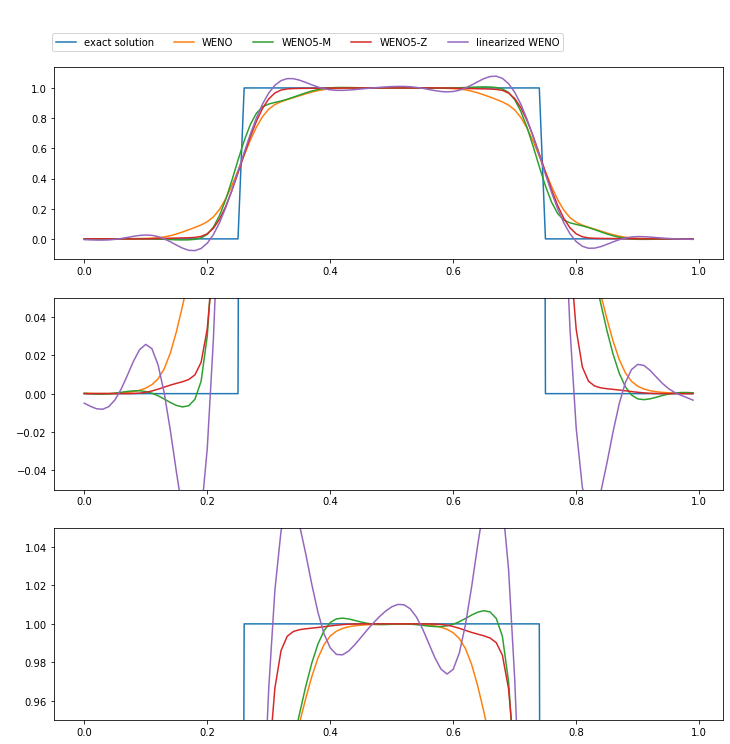

In [694]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 100
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  print(scheme.name)
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(num_param.X,u_0,label="exact solution",color=default.palette[0])
ax2.plot(num_param.X,u_0,color=default.palette[0])
ax3.plot(num_param.X,u_0,color=default.palette[0])
i=0
for scheme,u in schemes_u.items():
  ax1.plot(num_param.X,u,label=scheme.name,color=default.palette[(i+1)%len(default.palette)])
  ax2.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  ax3.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  i+=1

ax2.set_ylim([-0.05,0.05])
ax3.set_ylim([0.95,1.05])
fig.legend(loc=(0.071,0.93),ncol=len(schemes_u)+1)
fig.show()

for scheme,u in schemes_u.items():
  print(scheme.name,sum(u<0))

del u_0,fig,ax1,ax2,ax3,num_param,schemes_u,scheme,u,i


WENO
WENO5-M
WENO5-Z
linearized WENO
WENO 3
WENO5-M 8
WENO5-Z 0
linearized WENO 13


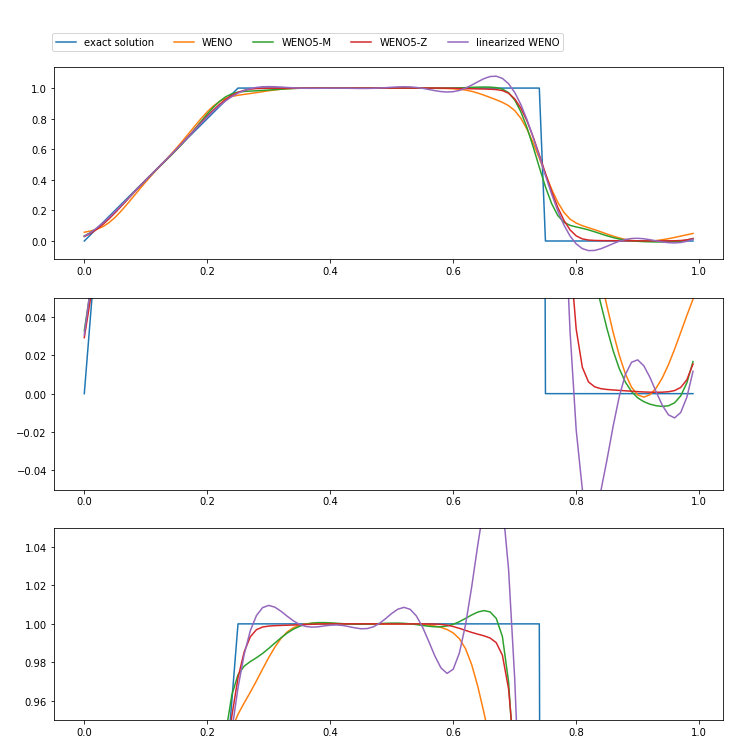

In [695]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 100
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  print(scheme.name)
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(num_param.X,u_0,label="exact solution",color=default.palette[0])
ax2.plot(num_param.X,u_0,color=default.palette[0])
ax3.plot(num_param.X,u_0,color=default.palette[0])
i=0
for scheme,u in schemes_u.items():
  ax1.plot(num_param.X,u,label=scheme.name,color=default.palette[(i+1)%len(default.palette)])
  ax2.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  ax3.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  i+=1

ax2.set_ylim([-0.05,0.05])
ax3.set_ylim([0.95,1.05])
fig.legend(loc=(0.071,0.93),ncol=len(schemes_u)+1)
fig.show()

for scheme,u in schemes_u.items():
  print(scheme.name,sum(u<0))

del u_0,fig,ax1,ax2,ax3,num_param,schemes_u,scheme,u,i

WENO
WENO5-M
WENO5-Z
linearized WENO
WENO 17
WENO5-M 21
WENO5-Z 0
linearized WENO 26


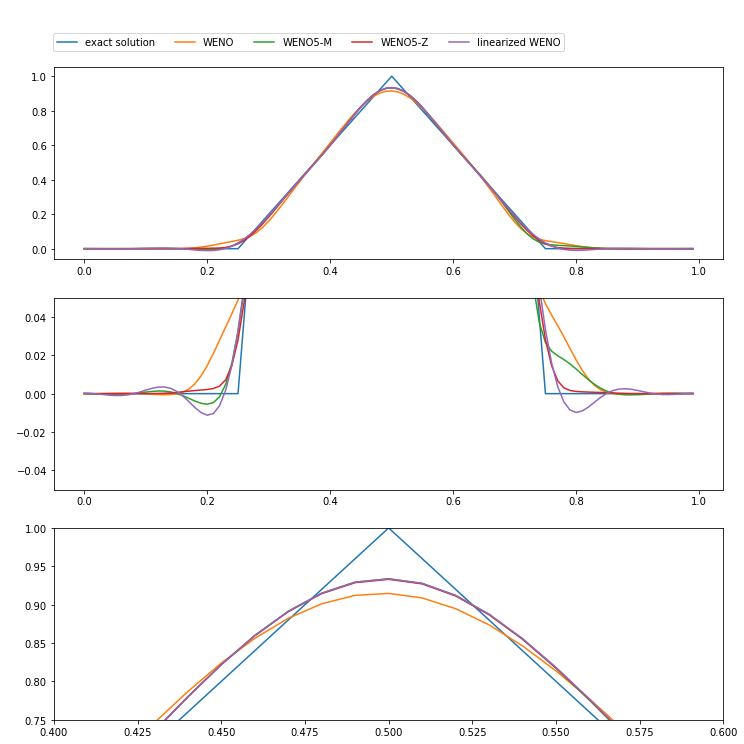

In [697]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = (4.*num_param.X-1)*(num_param.X*(num_param.X<=0.5)>0.25) + (-4.*num_param.X+3)*(num_param.X*(num_param.X<0.75)>0.5)

num_param.Tf = 100
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno5m,weno5z,weno5l):
  print(scheme.name)
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,12))
ax1.plot(num_param.X,u_0,label="exact solution",color=default.palette[0])
ax2.plot(num_param.X,u_0,color=default.palette[0])
ax3.plot(num_param.X,u_0,color=default.palette[0])
i=0
for scheme,u in schemes_u.items():
  ax1.plot(num_param.X,u,label=scheme.name,color=default.palette[(i+1)%len(default.palette)])
  ax2.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  ax3.plot(num_param.X,u,color=default.palette[(i+1)%len(default.palette)])
  i+=1

ax2.set_ylim([-0.05,0.05])
ax3.set_ylim([0.75,1]); ax3.set_xlim([0.4,0.6])
fig.legend(loc=(0.071,0.93),ncol=len(schemes_u)+1)
fig.show()

for scheme,u in schemes_u.items():
  print(scheme.name,sum(u<0))

del u_0,fig,ax1,ax2,ax3,num_param,schemes_u,scheme,u,i

## B-WENO

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) est proposé une modification du schéma WENO plus intéressante pour l'étude de l'équation de Vlasov. Nous étudierons ici la présentation effectuée dans la seconde publication. Dans la continuation des schémas d'ordre élevé en espace, nous nous intéresserons au schéma BWENO d'ordre 6 présenté.

L'idée de ce schéma reste similaire à celle du WENO dans l'esprit du calcul de poids non linéaire s'adaptant aux irrégularités de la fonction. Le nombre de poids est en revanche limité à 2, et ceux-ci ne sont plus des polynôme en $\left(f_{i+k}^4\right)_{k\in [\![ -3,3 ]\!]}$ mais seulement de degré 2 : $\left(f_{i+k}^2\right)_{k\in [\![ -3,3 ]\!]}$. Cette diminution du nombre de multiplication peut rendre ce schéma compétitif au niveau du temps de calcul. Les solutions attendues dans la simulation de plasmas avec l'équation de Vlasov-Poisson sont régulières, l'ordre élevé des schémas sert à capturer les forts gradients de la solution qui peuvent apparaître lors de la filamentation.

Le flux $\hat{u}^{(B)}_{j-\frac{1}{2}}$ du schéma BWENO d'ordre $p$ s'obtient par l'addition pondéré de 2 interpolations $L$ et $R$, d'ordre $p-1$. Nous ne nous intéresserons ici qu'à la méthode d'ordre 6, nous nous abstiendrons donc d'indiquer l'ordre.

$$
  \hat{u}^{(B)}_{j-\frac{1}{2}} = w^{(L)}_{j-\frac{1}{2}}u^{(L)}_{j-\frac{1}{2}} + w^{(R)}_{j-\frac{1}{2}}u^{(R)}_{j-\frac{1}{2}}
$$

L'écriture du schéma commence par l'estimation des indicateurs de continuité :

$$
  \begin{aligned}
      \beta(u_i) = (\Delta^1_4u_i)\left( (\Delta^1_4u_i) + (\Delta^2_4u_i) + \frac{1}{3}(\Delta^3_2u_i) + \frac{1}{12}(\Delta^4_2u_i) \right) \\
      + (\Delta^2_4u_i)\left( \frac{4}{3}(\Delta^2_4u_i) + \frac{5}{4}(\Delta^3_2u_i) + \frac{2}{5}(\Delta^4_2u_i) \right) \\
      + (\Delta^3_2u_i)\left( \frac{83}{60}(\Delta^3_2u_i) + \frac{23}{18}(\Delta^4_2u_i) \right) \\
      + \frac{437}{315}(\Delta^4_2u_i)^2
  \end{aligned}
$$

où les $(\Delta^d_pu_i)$ sont des approximations d'ordre $p$ de la dérivée d'ordre $d$ :

$$
  \begin{aligned}
    (\Delta^1_4u_i) &= \frac{1}{12}\left( -u_{j+2} +  8u_{j+1}           -  8u_{j-1} + u_{j-2} \right) \\
    (\Delta^2_4u_i) &= \frac{1}{12}\left( -u_{j+2} + 16u_{j+1} - 30u_{j} + 16u_{j-1} - u_{j-2} \right) \\
    (\Delta^3_2u_i) &=  \frac{1}{2}\left(  u_{j+2} -  2u_{j+1}           +  2u_{j-1} - u_{j-2} \right) \\
    (\Delta^4_2u_i) &=             \left(  u_{j+2} -  4u_{j+1} +  6u_{j} -  4u_{j-1} + u_{j-2} \right) \\
  \end{aligned}
$$

Nous prendrons $\beta^{(L)}_{j-\frac{1}{2}} = \beta(u_{j-1})$ et $\beta^{(R)}_{j-\frac{1}{2}} = \beta(u_j)$ comme indicateurs de continuité respectivement à gauche et à droite.

Les 2 poids non normalisés sont :

$$
  a^{(\Xi)}_{j-\frac{1}{2}} = \frac{d}{\epsilon + \beta^{(\Xi)}_{j-\frac{1}{2}}}
$$

où $\Xi = L,R$, $d=\frac{1}{2}$ et $\epsilon$ un paramètre pour éviter la nullité du dénominateur. Ce qui nous donne les poids :

$$
  \tilde{w}^{(\Xi)}_{j-\frac{1}{2}} = \frac{a^{(\Xi)}_{j-\frac{1}{2}}}{a^{(L)}_{j-\frac{1}{2}}+a^{(R)}_{j-\frac{1}{2}}}
$$

Les poids sont ensuites classé selon la direction, ici pour une vitesse positive (dans l'étude du schéma nous prendrons $v=1$) :

$$
  \begin{cases}
    w^{(L)} = \max\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right) \\
    w^{(R)} = \min\left(\tilde{w}^{(L)}_{j-\frac{1}{2}},\tilde{w}^{(R)}_{j-\frac{1}{2}}\right)
  \end{cases}
$$

Les flux à gauche et à droite sont maintenant calculés comme suit :

$$
  \begin{cases}
    \hat{u}^{(L)}_{j-\frac{1}{2}} = \frac{1}{60}\left( -3u_{j+1}+27u_{j}+47u_{j-1} -13u_{j-2} + 2u_{j-3} \right) \\
    \hat{u}^{(R)}_{j-\frac{1}{2}} = \frac{1}{60}\left( 2u_{j+2}-13u_{j+1}+47u_{j}+27u_{j-1}-3u_{j-2}  \right) \\
  \end{cases}
$$

On peut enfin calculer une approximation de $\partial_x u$ à l'aide du flux de BWENO par :

$$
  \partial_x u \approx \frac{1}{\Delta x}\left( \hat{u}^{(B)}_{j+\frac{1}{2}} - \hat{u}^{(B)}_{j-\frac{1}{2}} \right)
$$

> Pour l'étude du schéma BWENO, l'article [[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) propose une linéarisation du schéma en prenant les poids $w^L$, $w^R$ égaux à différents couples de nombres positifs vérifiant que $w^L+w^R=1$, ainsi est tracé le coefficient d'amplification pour $w^L=1,\frac{3}{4},\frac{1}{2}$. En effet différents éléments empêche facilement d'écrire les poids sous la forme $w_i = \gamma_i + \mathcal{O}(\Delta x^2)$ comme les précédentes modifications du schéma WENO.

In [715]:
def bweno5_flux ( wl=None , wr=None ) :
  """
    return expression of all BWENO scheme
    it could be linearized with optional special weight `wl` and `wr`. By default it is not linearized,
    if only `wl` is done then `wr = 1-wl`.
  """
  
  def beta ( k ) :
    """
      Indicator of smootheness of BWENO method
    """
    D14uj = sp.Rational(1,12)*( -f(k+2) +  8*f(k+1)             -  8*f(k-1) + f(k-2) )
    D24uj = sp.Rational(1,12)*( -f(k+2) + 16*f(k+1) - 30*f(k+0) + 16*f(k-1) - f(k-2) )
    D32uj =  sp.Rational(1,2)*(  f(k+2) -  2*f(k+1)             +  2*f(k-1) - f(k-2) )
    D42uj =                   (  f(k+2) -  4*f(k+1) +  6*f(k+0) -  4*f(k-1) + f(k-2) )

    return ( D14uj*( D14uj + D24uj + sp.Rational(1,3)*D32uj + sp.Rational(1,12)*D42uj )
           + D24uj*( sp.Rational(4,3)*D24uj + sp.Rational(5,4)*D32uj + sp.Rational(2,5)*D42uj )
           + D32uj*( sp.Rational(83,60)*D32uj + sp.Rational(23,18)*D42uj )
           + sp.Rational(437,315)*D42uj*D42uj )
  
  if wl==None :
    b5Rjm12 = beta(0)
    b5Ljm12 = beta(-1)

    a5Ljm12 = sp.Rational(1,2)/( epsilon + b5Ljm12 )
    a5Rjm12 = sp.Rational(1,2)/( epsilon + b5Rjm12 )
    
    wt5Ljm12 = a5Ljm12 / ( a5Ljm12 + a5Rjm12 )
    wt5Rjm12 = a5Rjm12 / ( a5Ljm12 + a5Rjm12 )
    
    w5Ljm12 = sp.Max(wt5Ljm12,wt5Rjm12)
    w5Rjm12 = sp.Min(wt5Ljm12,wt5Rjm12)
  else :
    w5Ljm12 = wl
    if wr == None:
      w5Rjm12 = 1-wl
    else:
      w5Rjm12 = wr
  
  u5Ljm12 = sp.Rational(1,60)*( -3*f(+1) + 27*f(+0) + 47*f(-1) - 13*f(-2) + 2*f(-3) )
  u5Rjm12 = sp.Rational(1,60)*(  2*f(+2) - 13*f(+1) + 47*f(+0) + 27*f(-1) - 3*f(-2) )
  
  u6Bjm12 = w5Ljm12*u5Ljm12 + w5Rjm12*u5Rjm12
  u6Bjp12 = u6Bjm12.subs(symbols_to(f_stencil, lambda j,_:f(j+1)),simultaneous=True)
  return u6Bjp12-u6Bjm12

bweno5 = Data()
bweno5.name = "B-WENO"
bweno5.flux = bweno5_flux
del bweno5_flux

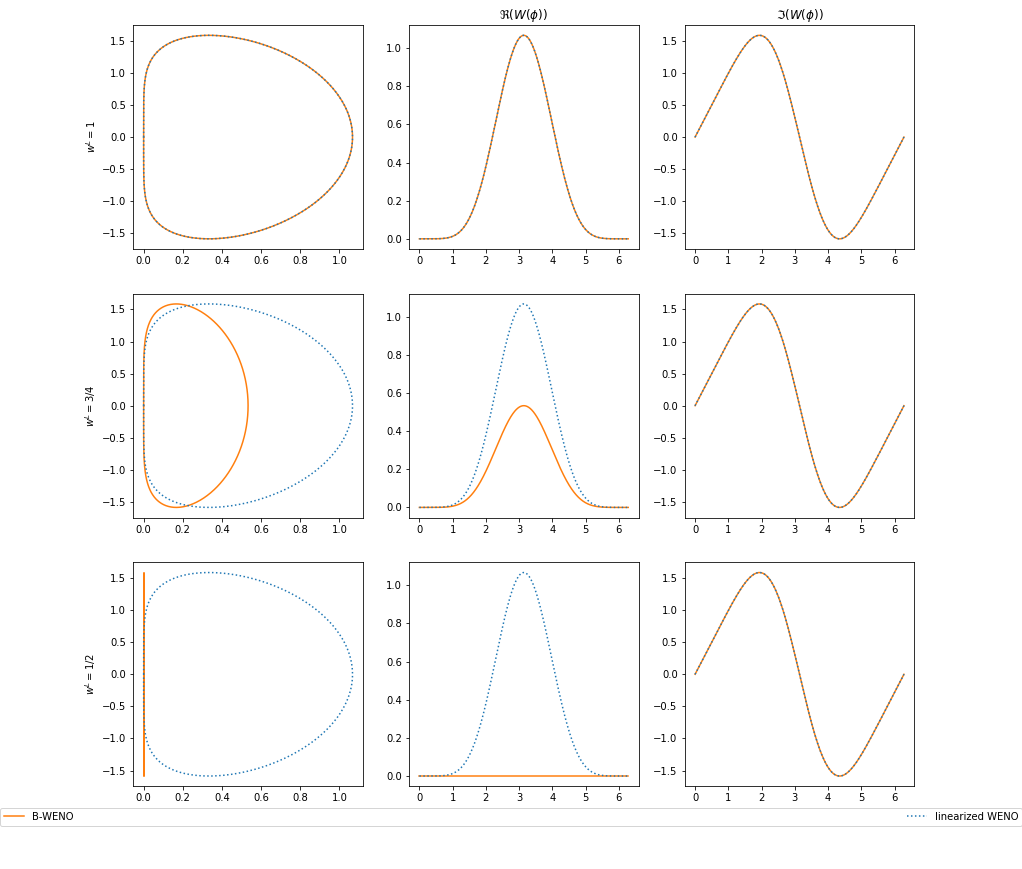

In [750]:
bweno5.wl = Data()
bweno5.wl.values = (1,sp.Rational(3,4),sp.Rational(1,2))
bweno5.wl.func = [ sp.lambdify(phi,bweno5.flux(wl).subs(symbols_to_vonNeumann(f_stencil)).subs(epsilon,10**(-8)),'numpy') for wl in bweno5.wl.values ]
bweno5.wl.data = [ f(data.phi) for f in bweno5.wl.func ]

fig, ax = plt.subplots(nrows=len(bweno5.wl.values),ncols=3,figsize=(14,14))

weno5l.ztilde.re,weno5l.ztilde.im = reim(weno5l.ztilde.data)

for i,wl in enumerate(bweno5.wl.values) :
  tmp_re,tmp_im = reim(bweno5.wl.data[i])
  ax[i][0].plot(tmp_re,tmp_im,label=bweno5.name,color=default.palette[1])
  ax[i][0].plot(weno5l.ztilde.re,weno5l.ztilde.im,':',label=weno5l.name,color=default.palette[0])
  ax[i][0].set_ylabel("$w^L = {}$".format(wl))
  
  ax[i][1].plot(data.phi,tmp_re,label=bweno5.name,color=default.palette[1])
  ax[i][1].plot(data.phi,weno5l.ztilde.re,':',label=weno5l.name,color=default.palette[0])
  
  ax[i][2].plot(data.phi,tmp_im,label=bweno5.name,color=default.palette[1])
  ax[i][2].plot(data.phi,weno5l.ztilde.im,':',label=weno5l.name,color=default.palette[0])

ax[0][1].title.set_text("$\\Re(W(\phi))$")
ax[0][2].title.set_text("$\\Im(W(\phi))$")
handles, labels = fig.gca().get_legend_handles_labels()
fig.legend(handles,labels,loc=(0.,0.05),ncol=2,mode="expand",borderaxespad=0.)
plt.show()

del fig,ax,i,wl,handles,labels

En linéarisant les poids ($w^L=1,\frac{3}{4},\frac{1}{2}$), on remarque un comportement similaire à celui du schéma WENO linéarisé (qui coïncide parfaitement pour $w^L=1$, $w^R=0$), avec un comportement dégénéré dans le cas centré $w^L = w^R = \frac{1}{2}$ (transport pur sans diffusion). La partie imaginaire, même dans le cas non linéarisé, la méthode BWENO reproduit le même comportement que la méthode WENO linéarisée.

In [733]:
def _bweno5(u_i,dx):
  """
    _bweno5
    return the B-WENO approximation of $\partial_x u$
  """
  #u_ip3 = np.array([*u_i[3:],*u_i[:3]])
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])
  u_im3 = np.array([*u_i[-3:],*u_i[:-3]])

  def _beta(uim2,uim1,ui,uip1,uip2):
    d14u = 1./12.*(-uip2 -  8.*uip1 - 8.*uim1 + uim2)
    d24u = 1./12.*(-uip2 + 16.*uip1 - 30.*ui + 16.*uim1 - uim2)
    d32u = 0.5*(uip1 - 2.*uip1 + 2.*ui - uim2)
    d42u = uip2 - 4.*uip1 + 6.*ui - 4.*uim1 + uim2
    return ( d14u*(d14u + d24u + 1./3.*d32u + 1./12.*d42u)
           + d24u*(4./3.*d24u + 1.25*d32u + 0.4*d42u)
           + d32u*(83./60.*d32u + 23./18.*d42u)
           + 437./315.*d42u*d42u)

  betaL = _beta(u_im3,u_im2,u_im1,u_i  ,u_ip1)
  betaR = _beta(u_im2,u_im1,u_i  ,u_ip1,u_ip2)
  alphaL,alphaR = [ 0.5/(1e-16 + b) for b in (betaL,betaR) ]
  sum_alpha = alphaL+alphaR
  wtL,wtR = [ a/sum_alpha for a in (alphaL,alphaR) ]
  wL = np.maximum(wtL,wtR)
  wR = np.minimum(wtL,wtR)

  uL = 1./60.*( -3.*u_ip1 + 27.*u_i   + 47.*u_im1 - 13.*u_im2 + 2.*u_im3 )
  uR = 1./60.*(  2.*u_ip2 - 13.*u_ip1 + 47.*u_i   + 27.*u_im1 - 3.*u_im2 )
  uB = wL*uL + wR*uR

  uBp1 = np.array([*uB[1:],*uB[:1]])
  return (uBp1-uB)/dx
  
bweno5.func = _bweno5
del _bweno5

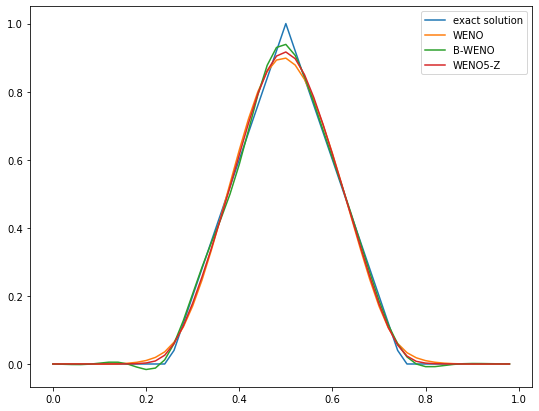

In [751]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = (4.*num_param.X-1)*(num_param.X*(num_param.X<=0.5)>0.25) + (-4.*num_param.X+3)*(num_param.X*(num_param.X<0.75)>0.5)

num_param.Tf = 10
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,bweno5,weno5z):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

On obtient un schéma qui diffuse moins que le schéma WENO-Z, il trouve ainsi son intérêt pour approximer au mieux des pics. Cela se fait au détriment du caractère oscillant.

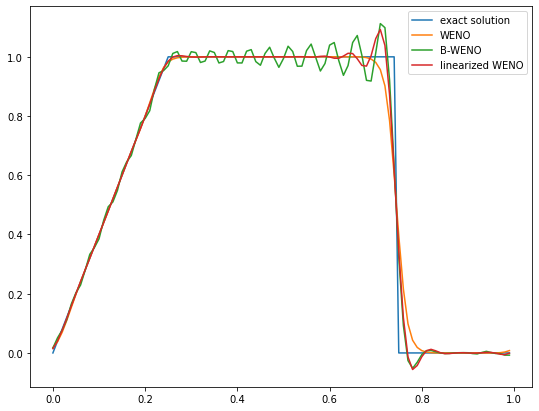

In [766]:
num_param = Data()
num_param.N = 100
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,bweno5,weno5l):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

On peut vérifier l'ordre du schéma. Pour cela on calcule l'erreur sur une advection à vitesse 1 :

$$
  \begin{cases}
    u_t + u_x = 0 \\
    u^0(x) = u(t=0,x) = \cos(2\pi x)
  \end{cases}
$$

On peut maintenant calculer l'ordre de la méthode sur ce problème de transport, en calculant la solution pour différents $\Delta x$ (on choisit différentes tailles de vecteur en entré), jusqu'au temps $T_f=1$ avec un pas de temps $\Delta t = \frac{1}{400}$ qui correspond environ à $\Delta t \leq \frac{1}{2}\Delta x_{\text{min}}$, pour minimiser l'erreur en temps.


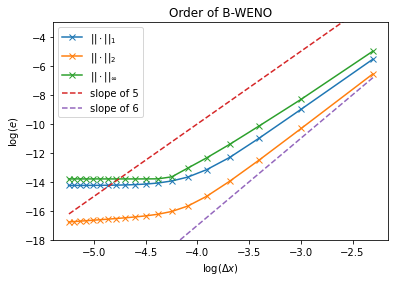

In [779]:
num_param = Data()
num_param.dt = 1./400
num_param.Tf = 1.

errors_bweno = []

for N in range(10,200,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_f = transport(u_0,rk33,lambda u,dx:-bweno5.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_bweno.append( (N,error(u_f,u_e)) )

space_steps = np.array([ 1./e[0] for e in errors_bweno ])

plt.title("Order of "+bweno5.name)
plt.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{1}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{2}$" )
plt.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_bweno ] , "x-" , label = r"$||\cdot||_{\infty}$" )
plt.plot( np.log(space_steps) , 5*np.log(space_steps)+10 , "--" , label = "slope of 5")
plt.plot( np.log(space_steps) , 6*np.log(space_steps)+7 , "--" , label = "slope of 6")
plt.xlabel(r"$\log(\Delta x)$")
plt.ylabel(r"$\log(e)$")
plt.legend()
plt.ylim([-18,-3])
plt.show()

del N,num_param,u_0,u_e,u_f,space_steps,errors_bweno

[[Banks J. W. et al (2019)]](https://github.com/Kivvix/miMaS/blob/master/bibliography/pdf/2019-Banks.pdf) annonce un ordre 6, mais ce n'est pas flagrant numériquement. Est-ce juste une définition différente de l'ordre ?

## WENO3

Après avoir présenté les méthodes WENO dites *classiques* que sont la méthode WENO d'ordre 5 et ses dérivées, attardons nous un peu sur la méthode WENO3, étrangement moins étudiée. La méthode est beaucoup plus succinte mais se présente de manière similaire avec un calcul d'indicateurs de continuité, puis de poids que l'on normalise, et enfin le calcul du flux.

Les indicateurs de continuités $\beta_0$ et $\beta_1$ se calculent comme suit :

$$
  \begin{aligned}
    \beta_0^+ &= \left(-f_{i-1}^+ + f_{i}^+\right)^2\\
    \beta_1^+ &= \left(-f_{i}^+ + f_{i+1}^+\right)^2
  \end{aligned}
$$

$$
  \begin{aligned}
    \beta_0^- &= \left(-f_{i+2}^- + f_{i+1}^-\right)^2\\
    \beta_1^- &= \left(-f_{i+1}^- + f_{i}^-\right)^2
  \end{aligned}
$$

Ensuite les poids :

$$
  \alpha_i^\pm = \frac{\gamma_i}{(\epsilon+\beta_i^\pm)^2}
$$

avec $\gamma_0 = \frac{1}{3}$ et $\gamma_1=\frac{2}{3}$ ; poids que l'on normalisent :

$$
  w_i^\pm = \frac{w_i}{w_0+w_1}
$$

Enfin le flux, définit par :

$$
  f_{i+\frac{1}{2}}^+ = w_0^+\left(-\frac{1}{2}f_{i-1}^+ + \frac{3}{2}f_i^+\right) + w_1^+\left(\frac{1}{2}f_i^++\frac{1}{2}f_{i+1}^+\right)
$$

$$
  f_{i+\frac{1}{2}}^- = w_0^-\left(-\frac{1}{2}f_{i+2}^- + \frac{3}{2}f_{i+1}^-\right) + w_1^-\left(\frac{1}{2}f_{i+1}^-+\frac{1}{2}f_{i}^-\right)
$$

La méthode WENO3 prend la forme finale :

$$
  (\partial_xf(u))(x_j) \approx \frac{1}{\Delta x}\left[ \left(f_{j+\frac{1}{2}}^+ - f_{j-\frac{1}{2}}^+ \right) + \left(f_{j+\frac{1}{2}}^- - f_{j-\frac{1}{2}}^- \right) \right]
$$

Pour l'étude de la stabilité nous ne prendrons que le cas $f^+(u) = u$ et $f^-(u) =0$

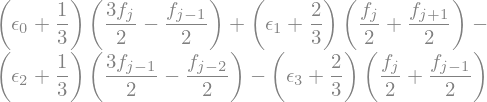

In [770]:
"""
linearized WENO method
"""
weno3l = Data()
weno3l.name = "linearized WENO3"

def weno3l_flux () :
  w0 = sp.Rational(1,3) + ei[0]
  w1 = sp.Rational(2,3) + ei[1]
  
  w2 = sp.Rational(1,3) + ei[2]
  w3 = sp.Rational(2,3) + ei[3]
  
  fjp12 = ( w0*( -sp.Rational(1,2)*f(-1) + sp.Rational(3,2)*f(+0) )
          + w1*(  sp.Rational(1,2)*f(+0) + sp.Rational(1,2)*f(+1) ) )
  fjm12 = fjp12.subs(symbols_to(f_stencil, lambda j,_:f(j-1)),simultaneous=True).subs({ei[0]:ei[2],ei[1]:ei[3]})
  
  return fjp12 - fjm12

weno3l.flux = weno3l_flux()
del weno3l_flux
display(weno3l.flux)

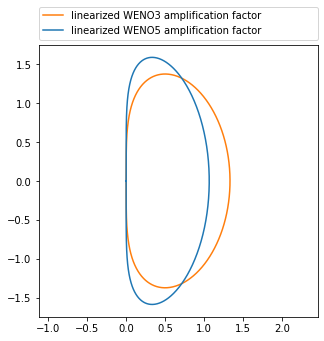

In [775]:
weno3l.ztilde = Data()

weno3l.ztilde.flux = weno3l.flux.expand().subs([(e,0) for e in ei])
weno3l.ztilde.func = sp.lambdify(phi,weno3l.ztilde.flux.subs(symbols_to_vonNeumann(f_stencil)),'numpy')
weno3l.ztilde.data = weno3l.ztilde.func(data.phi)

plt.rcParams['figure.figsize'] = [5,5]
plt.plot(*reim(weno3l.ztilde.data),label=weno3l.name+" amplification factor",color=default.palette[1])
plt.plot(*reim(weno5l.ztilde.data),label=weno5l.name+" amplification factor",color=default.palette[0])
plt.axis('equal')
plt.legend(loc=(0.,1.02),mode="expand",borderaxespad=0.)
plt.show()
plt.rcParams['figure.figsize'] = default.figsize

Comme indiqué dans la littérature, la méthode WENO3 diffuse plus que son équivalent d'ordre 5, cela se remarque par une plus grande partie imaginaire.

In [783]:
def _weno3(u_i,dx):
  """
    _weno3
    return the WENO3 approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  b0 = np.square( -u_im1 + u_i   )
  b1 = np.square( -u_i   + u_ip1 )

  alpha  = [ g_i/np.square(b_i+1e-6) for b_i,g_i in zip((b0,b1),(1./3.,2./3.)) ]
  sum_alpha = sum(alpha)
  w0,w1 = [ a_i/sum_alpha for a_i in alpha ]

  fip12 = w0*( -0.5*u_im1 + 1.5*u_i ) + w1*( 0.5*u_i + 0.5*u_ip1 )
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

def _weno3l(u_i,dx):
  """
    _weno3l
    return the linearized WENO3 approximation of $\partial_x u$
  """
  u_ip2 = np.array([*u_i[2:],*u_i[:2]])
  u_ip1 = np.array([*u_i[1:],*u_i[:1]])
  u_im1 = np.array([*u_i[-1:],*u_i[:-1]])
  u_im2 = np.array([*u_i[-2:],*u_i[:-2]])

  w0,w1 = (1./3.,2./3.)

  fip12 = w0*( -0.5*u_im1 + 1.5*u_i ) + w1*( 0.5*u_i + 0.5*u_ip1 )
  fim12 = np.array([*fip12[-1:],*fip12[:-1]])

  return (fip12-fim12)/dx

weno3l.func = _weno3l

weno3 = Data()
weno3.name = "WENO3"
weno3.func = _weno3
del _weno3,_weno3l

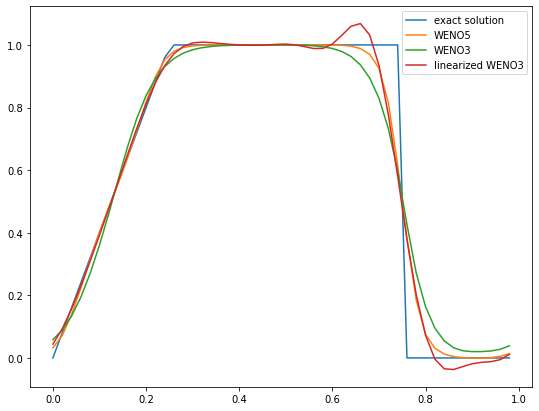

In [785]:
num_param = Data()
num_param.N = 50
num_param.X = np.linspace(0.,1.,num_param.N,endpoint=False)
u_0 = 4.*num_param.X*(num_param.X<=0.25) + 1.*(num_param.X*(num_param.X<0.75)>0.25)

num_param.Tf = 1
num_param.dt = 0.1/num_param.N # = 0.1*dx

schemes_u = {}
for scheme in (weno5,weno3,weno3l):
  schemes_u[scheme] = transport(u_0,rk33,lambda u,dx:-scheme.func(u,dx),num_param.Tf,num_param.dt)

plt.rcParams['figure.figsize'] = [9,7]

plt.plot(num_param.X,u_0,label="exact solution")
for scheme,u in schemes_u.items():
  plt.plot(num_param.X,u,label=scheme.name)
plt.legend()
plt.show()

plt.rcParams['figure.figsize'] = default.figsize
del u_0, num_param,schemes_u

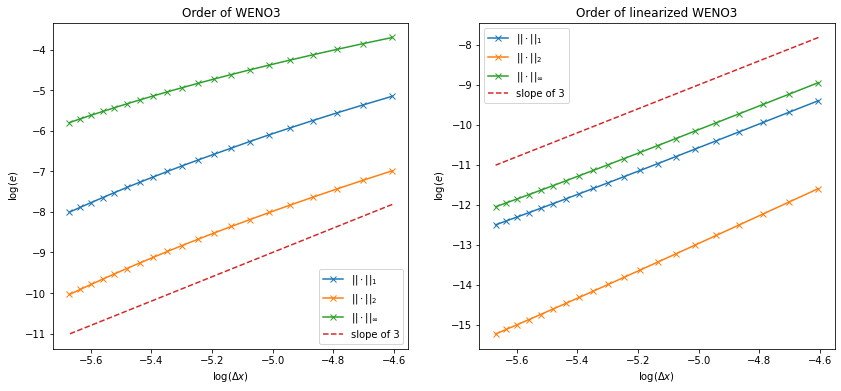

In [797]:
num_param = Data()
num_param.dt = 1./500
num_param.Tf = 1.

errors_weno3l = []
errors_weno3  = []

for N in range(100,300,10):
    num_param.X = np.linspace(0.,1.,N,endpoint=False)
    u_0 = np.cos(2.*np.pi*num_param.X)
    u_e = np.cos(2.*np.pi*(num_param.X - num_param.Tf))
    u_fl = transport(u_0,rk33,lambda u,dx:-weno3l.func(u,dx),num_param.Tf,num_param.dt)
    u_f  = transport(u_0,rk33,lambda u,dx:-weno3.func(u,dx) ,num_param.Tf,num_param.dt)
    errors_weno3l.append( (N,error(u_fl,u_e)) )
    errors_weno3.append( (N,error(u_f,u_e)) )

del N,num_param,u_0,u_e,u_fl,u_f

space_steps = np.array([ 1./e[0] for e in errors_weno3 ])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6))

ax1.set_title("Order of "+weno3.name)
ax1.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{1}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{2}$" )
ax1.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno3 ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax1.plot( np.log(space_steps) , 3*np.log(space_steps)+6 , "--" , label = "slope of 3")
ax1.set_xlabel(r"$\log(\Delta x)$")
ax1.set_ylabel(r"$\log(e)$")
ax1.legend()

ax2.set_title("Order of "+weno3l.name)
ax2.plot( np.log(space_steps) , [ np.log(e[1].n1) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{1}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].n2) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{2}$" )
ax2.plot( np.log(space_steps) , [ np.log(e[1].noo) for e in errors_weno3l ] , "x-" , label = r"$||\cdot||_{\infty}$" )
ax2.plot( np.log(space_steps) , 3*np.log(space_steps)+6 , "--" , label = "slope of 3")
ax2.set_xlabel(r"$\log(\Delta x)$")
ax2.set_ylabel(r"$\log(e)$")
ax2.legend()

plt.show()

del fig,ax1,ax2,space_steps,errors_weno3l,errors_weno3

Voilà qui conclu l'étude des schémas en espace.

# Discrétisation en temps

## Méthodes Runge-Kutta explicites